In [1]:
%load_ext autoreload

In [2]:
import os
import torch
import parkinson

import numpy as np

from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

In [3]:
RDN = 50
N_CLASSES = 3
BATCH_SIZE = 64
N_EPOCHS = 200
PATIENCE = 20
LR = 0.0001
DECAY = 0.000001
SAVE_PATH = '../outputs/2_timeseries'

# Processamento dos dados

In [ ]:
# Lendo os dados dos arquivos.
print('Started file reading...')
parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns')
prodomal_data = parkinson.utils.data.batch_read('../data/Prodomals_columns')
print('File reading completed.')

# Selecionando o atlas (estratégia de divisão cerebral: Shen_268 ou atlas ou AAL3).
control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')
prodomal_atlas_data = parkinson.utils.data.select_atlas_columns(prodomal_data, 'AAL3')

# Transformando os dados selecionados em séries temporais (shape = [n_pacientes, n_canais, n_observações]).
control_ts_data = parkinson.utils.data.df_to_timeseries(control_atlas_data)
parkinson_ts_data = parkinson.utils.data.df_to_timeseries(parkinson_atlas_data)
prodomal_ts_data = parkinson.utils.data.df_to_timeseries(prodomal_atlas_data)

# Misturando pacientes Controle/Parkinson e trocando valores NaN por zero.
X = parkinson.utils.data.concatenate_data(parkinson_ts_data, control_ts_data, prodomal_ts_data)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))], [2 for _ in range(len(prodomal_data))])
X, y = parkinson.utils.data.filter_data(X, y)

# Separando os dados em 60% treino, 20% validação e 20% teste.
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=RDN, stratify=y_trainval, shuffle=True)

# Criando DataLoader
train_loader = parkinson.utils.data.get_torch_dataloader(X_train, y_train, batch_size=BATCH_SIZE)
val_loader = parkinson.utils.data.get_torch_dataloader(X_val, y_val, batch_size=BATCH_SIZE)
test_loader = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE)

Started file reading...


100%|██████████| 188/188 [00:04<00:00, 43.16it/s]


File reading completed.


# Treinamento

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.customFCN(X_train.shape[1], N_CLASSES)

model.train()
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

out = parkinson.utils.train.train(model, train_loader, val_loader, device, N_EPOCHS, PATIENCE, LR, "../weights/2_time_series", DECAY)

metrics = parkinson.utils.train.evaluate(model, test_loader, device, "../weights/2_time_series")

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]/home/labic/merlin_codes/dl/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(
train-loss: 0.0379  train-acc: 1.0000 | val-loss: 0.9961  val-acc: 0.4756:  26%|██▌       | 52/200 [00:27<01:18,  1.89it/s]

Early stopping at epoch 53



/home/labic/merlin_codes/dl/Parkinson-Diagnosis-Deeplearning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Análise dos resultados

 Acurácia       F1  Precisão   Recall
 0.536585 0.457825  0.496791 0.536585


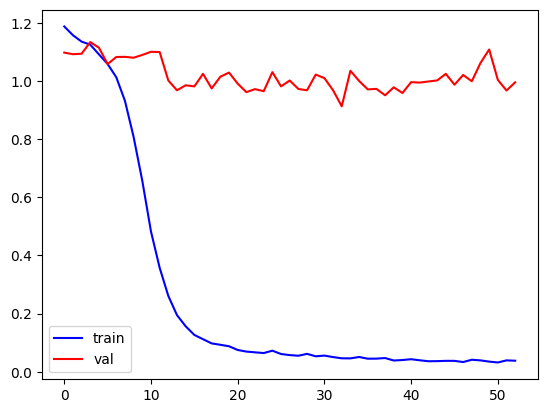

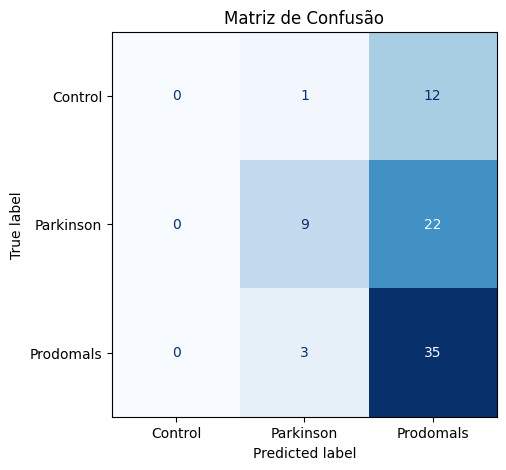

In [6]:
# Criando e plotando os resultados.
parkinson.utils.results.metrics_to_dataframe(metrics)
fig_loss = parkinson.utils.results.plot_losses(out['train_loss'],out['val_loss'])
fig_loss.show()
fig_cf = parkinson.utils.results.plot_confusion_matrix(metrics['preds'], metrics['labels'], class_names=['Control','Parkinson', 'Prodomals'])
fig_cf.show()

# Salvando as figuras.
fig_loss.savefig(f"{SAVE_PATH}/loss_curve.png", bbox_inches='tight')
fig_cf.savefig(f"{SAVE_PATH}/confusion_matrix.png", bbox_inches='tight')